In [227]:
import numpy as np
import networkx as nx
import math
import random
import matplotlib.pyplot as plt

In [228]:
## parameters

packetLength = 20 # in bytes
avgSendTime = 90000

# define the maximum simulation area
maxX = 1000 # in m
maxY = 1000 # in m

# lets use a constant ratio here
nrBS = 10
nrNodes = 10000

# log shadow model parameters
Ptx = 15 # in dBm
gamma = 2.2394
# d0 = 40.0 # in m
d0 = 40.0 # from drive tests
var = 0 # variance ignored for now. 
# Lpld0 = 127.41
Lpld0 = 95.0038 # from drive test
GL = 0
nSF = 6 # spreading factors available = 6

def dBmtomW(pdBm):
    pmW = 10**(pdBm/10.0)
    return pmW

def dBmtofW(pdBm):
    pfW = 10**((pdBm+90.0)/10.0)
    return pfW

def getRXPower(pTX, distance):
    # get ideal RX power estimate assuming log-distance model
    pRX = pTX - Lpld0 - 10.0*gamma*np.log10(distance/d0)
    return pRX
    
def getTXPower(pRX, distance):
    # get ideal TX power estimate assuming log-distance model
    pTX = pRX + Lpld0 + 10.0*gamma*np.log10(distance/d0)
    return pTX

def getDistanceFromPL(pTX, pRX):
    d = d0*10**((pTX-pRX-Lpld0)/(10.0*gamma))
    return d

## order: spreading factor, 125 kHz, 250 kHz, 500 kHz
sensi = np.array([[7,-126.5,-124.25,-120.75],
                 [8,-127.25,-126.75,-124.0],
                 [9,-131.25,-128.25,-127.5],
                 [10,-132.75,-130.25,-128.75],
                 [11,-134.5,-132.75,-128.75],
                 [12,-133.25,-132.25,-132.25]])

def airtime(sf,cr,pl,bw):
    H = 0        # implicit header disabled (H=0) or not (H=1)
    DE = 0       # low data rate optimization enabled (=1) or not (=0)
    Npream = 8   # number of preamble symbol (12.25  from Utz paper)

    if bw == 125 and sf in [11, 12]:
        # low data rate optimization mandated for BW125 with SF11 and SF12
        DE = 1
    if sf == 6:
        # can only have implicit header with SF6
        H = 1

    Tsym = (2.0**sf)/bw
    Tpream = (Npream + 4.25)*Tsym
    payloadSymbNB = 8 + max(math.ceil((8.0*pl-4.0*sf+28+16-20*H)/(4.0*(sf-2*DE)))*(cr+4),0)
    Tpayload = payloadSymbNB * Tsym
    return Tpream + Tpayload

def getUSMaxTransmitDistance(RXSensi, pTX, plen):
    """
    Based on the transmit time and bandwidth used, get the parameters which give the best range for allowed power.
    This is dependent on the packet length as the max transmission size is also limited.
    
    TODO: Similar functions should be defined for other regions.
    """
    # Allowed max power for each bandwidth in the US
    
    PTx125 = min(30,pTX) # in dBm
    PTx500 = min(26,pTX) # in dBm
    
    # The US spec doesn't have a 250 kHz option (and there is no good reason to use it)
    Lpl125 = PTx125 - RXSensi[:,1]
    Lpl500 = PTx500 - RXSensi[:,3]
    
    LplMatrix = np.concatenate((Lpl125.reshape((6,1)), Lpl500.reshape((6,1))), axis=1)
    distMatrix = np.dot(d0, np.exp(np.divide(LplMatrix - Lpld0, 10*gamma)))
    
    packetAirtimeValid = np.zeros((6,2))
    for i in xrange(6):
        packetAirtimeValid[i,0] = (airtime(i+7, 1, plen, 125) <= 400)
        packetAirtimeValid[i,1] = (airtime(i+7, 1, plen, 500) <= 400)
        
    Index = np.argmax(np.multiply(distMatrix, packetAirtimeValid))
    
    sfInd, bwInd = np.unravel_index(Index, (6,2))
    
    if packetAirtimeValid[sfInd, bwInd] == 0:
        raise ValueError("packet length too large")
    
    maxSF = sfInd + 7
    if bwInd == 0:
        maxBW = 125
    else:
        maxBW = 500
    
    return distMatrix[sfInd,bwInd], maxSF, maxBW

## Place base-stations randomly
BSLoc = np.zeros((nrBS, 5))
nodeLoc = np.zeros((nrNodes, 9))

# bestDist, bestSF, bestBW = getUSMaxTransmitDistance(sensi, packetLength)
bestSF = 10 # for max range
bestBW = 125 # for max range
bestDist = getDistanceFromPL(Ptx, sensi[bestSF-7, 1+(bestBW/250)])

print getUSMaxTransmitDistance(sensi, Ptx, packetLength)

print "Ptx = {}".format(Ptx)
print "sesitivity = {}".format(sensi[bestSF-7, 1+(bestBW/250)])
print "max distance = {}".format(bestDist)

(421.6819802995513, 10, 125)
Ptx = 15
sesitivity = -132.75
max distance = 9066.33925485


In [229]:
def placeRandomly(number, locArray, xRange, yRange):
    for n in xrange(number):
        x = random.uniform(xRange[0], xRange[1])
        y = random.uniform(yRange[0], yRange[1])
        locArray[n,:] = [n, x, y, -1, 0]
        
def placeRandomlyInRange(number, locArray, xRange, yRange, refLoc):
    for n in xrange(number):
#         rounds = 0
        while True:
            # This could technically turn into an infinite loop but that shouldn't ever practically happen.
            # add check here later
            x = random.uniform(xRange[0], xRange[1])
            y = random.uniform(yRange[0], yRange[1])
            if np.any(np.sum(np.square(refLoc[:,1:3] - np.array([x,y]).reshape(1,2)), axis=1) <= bestDist**2):
                locArray[n,:] = [n, x, y, -1, 125, -1, 1, -1, avgSendTime]
                break
        
print "===== Location generation ====="

# seed the random generator
random.seed(1)

print "Max range = {} at SF = {}, BW = {}".format(bestDist, bestSF, bestBW)

if nrBS == 1:
    BSLoc[0] = [0, maxX*0.5, maxY*0.5, 0, 0]
else:
    placeRandomly(nrBS, BSLoc, [maxX*0.1, maxX*0.9], [maxY*0.1, maxY*0.9])
print "generated locations for {} base-stations".format(nrBS)

placeRandomlyInRange(nrNodes, nodeLoc, [0, maxX], [0, maxY], BSLoc)
print "generated locations for {} nodes".format(nrNodes)

===== Location generation =====
Max range = 9066.33925485 at SF = 10, BW = 125
generated locations for 10 base-stations
generated locations for 10000 nodes


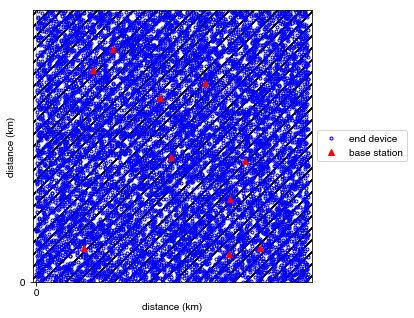

In [230]:
def plotLocations():
    loc_plot = plt.figure(figsize = (5,5))
    loc_ax = plt.gca()
    
    for b in BSLoc[:,1:3]:
        loc_ax.add_artist(plt.Circle((b[0], b[1]), bestDist, fill=False, hatch='//', color = 'red'))
    
    nodePoints, = plt.plot(nodeLoc[:,1], nodeLoc[:,2], "b.", mfc='none', label="end device")
    bsPoints, = plt.plot(BSLoc[:,1], BSLoc[:,2], "r^", label="base station")
    
    plt.xticks([0, 5000, 10000, 15000, 20000], [0,5,10,15,20])
    plt.yticks([0, 5000, 10000, 15000, 20000], [0,5,10,15,20])
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
    plt.axis('equal')
    plt.xlim((0, maxX))
    plt.ylim((0, maxY))
    
    plt.xlabel('distance (km)')
    plt.ylabel('distance (km)')
    
    plt.show()
    
plotLocations()

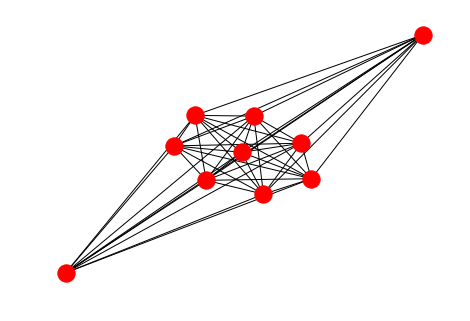

strategy_smallest_last = 10
[[   0.          207.49139529  777.94698955    1.            0.        ]
 [   1.          711.01969518  304.05522059    0.            0.        ]
 [   2.          496.34806967  459.59285183    7.            0.        ]
 [   3.          621.27437818  730.97868091    6.            0.        ]
 [   4.          175.08766942  122.67798122    5.            0.        ]
 [   5.          768.61208314  446.21365432    4.            0.        ]
 [   6.          709.82406597  101.68484268    3.            0.        ]
 [   7.          456.30975524  677.23202587    2.            0.        ]
 [   8.          283.00977702  856.21655644    1.            0.        ]
 [   9.          821.14196609  124.47198643    0.            0.        ]]


In [231]:
G = nx.Graph()
for i,bs in enumerate(BSLoc):
    bsid = int(bs[0])
    dist2 = (BSLoc[:,1] - bs[1])**2 + (BSLoc[:,2] - bs[2])**2
    index = np.nonzero(dist2 <= (2*bestDist)**2)
    G.add_node(bsid)
    for node in BSLoc[index,0][0]:
        if int(node) != bsid:
            G.add_edge(bsid, int(node))
#     print "BS: {}, ind: {}".format(bsid, ind)
    
nx.draw(G)
plt.show()

# coloring = nx.greedy_color(G, strategy = nx.coloring.strategy_largest_first)
# print "strategy_largest_first = {}".format(coloring[max(coloring, key=coloring.get)] + 1)

# coloring = nx.greedy_color(G, strategy = nx.coloring.strategy_random_sequential)
# print "strategy_random_sequential = {}".format(coloring[max(coloring, key=coloring.get)] + 1)

coloring = nx.greedy_color(G, strategy = nx.coloring.strategy_smallest_last)
print "strategy_smallest_last = {}".format(coloring[max(coloring, key=coloring.get)] + 1)

for i,color in coloring.viewitems():
    BSLoc[i,3] = color % 8
    
print BSLoc
    
# print BSLoc[:,3]

# coloring = nx.greedy_color(G, strategy = nx.coloring.strategy_independent_set)
# print "strategy_independent_set = {}".format(coloring[max(coloring, key=coloring.get)] + 1)

# coloring = nx.greedy_color(G, strategy = nx.coloring.strategy_connected_sequential_bfs)
# print "strategy_connected_sequential_bfs = {}".format(coloring[max(coloring, key=coloring.get)] + 1)

# coloring = nx.greedy_color(G, strategy = nx.coloring.strategy_connected_sequential_dfs)
# print "strategy_connected_sequential_dfs = {}".format(coloring[max(coloring, key=coloring.get)] + 1)

# coloring = nx.greedy_color(G, strategy = nx.coloring.strategy_saturation_largest_first)
# print "strategy_saturation_largest_first = {}".format(coloring[max(coloring, key=coloring.get)] + 1)


# plt.draw()

In [232]:
bucketLimit = (nrNodes/nrBS)/2

airtimeFactors = []

for sf in xrange(7,11):
    airtimeFactors.append(airtime(sf, 1, 20, 125)/airtime(7, 1, 20, 125))

bsDict = {}
for bs in xrange(BSLoc.shape[0]):
    for i in xrange(7,13):
        bsDict[bs, i] = 0

for i in xrange(nodeLoc.shape[0]):
    dist = np.sqrt((nodeLoc[i,1] - BSLoc[:,1])**2 + (nodeLoc[i,2] - BSLoc[:,2])**2)
    index = np.nonzero(dist < bestDist)
    
    # first fit algorithm
    sortedBSList = sorted(zip(index[0], dist[index]), key=lambda x: x[1])
    # get a sorted list of nodes and base-stations
#     print int(node[0])
    foundFlag = False
    for sf in xrange(7,11):
        if foundFlag:
            break
        for bs,dist in sortedBSList:
            # only checking for bandwidth 1
            if getRXPower(Ptx, dist) >= sensi[sf-7, 1]:
                # means I can recieve packets with this base-station
                if bsDict[bs, sf] + airtimeFactors[sf-7] <= bucketLimit:
                    bsDict[bs,sf] = bsDict[bs,sf] + airtimeFactors[sf-7]
                    p = np.ceil(max(min(getTXPower(sensi[sf-7, 1], dist), Ptx),0))
                    nodeLoc[i,3] = BSLoc[bs,3]
                    nodeLoc[i,4] = 125
                    nodeLoc[i,5] = sf
                    nodeLoc[i,6] = 1
                    nodeLoc[i,7] = p
                    nodeLoc[i,8] = 900000
                    foundFlag = True
                    print "node {}, color {}, sf {}, power {}".format(int(nodeLoc[i,0]), (nodeLoc[i,3]), (nodeLoc[i,5]), p)
                    break
                    
                
#     print len(sortedBSList), sortedBSList
    

node 0, color 1.0, sf 7.0, power 0.0
node 1, color 4.0, sf 7.0, power 0.0
node 2, color 7.0, sf 7.0, power 0.0
node 3, color 5.0, sf 7.0, power 0.0
node 4, color 7.0, sf 7.0, power 0.0
node 5, color 5.0, sf 7.0, power 0.0
node 6, color 7.0, sf 7.0, power 0.0
node 7, color 5.0, sf 7.0, power 0.0
node 8, color 4.0, sf 7.0, power 0.0
node 9, color 3.0, sf 7.0, power 0.0
node 10, color 6.0, sf 7.0, power 0.0
node 11, color 5.0, sf 7.0, power 0.0
node 12, color 6.0, sf 7.0, power 0.0
node 13, color 4.0, sf 7.0, power 0.0
node 14, color 6.0, sf 7.0, power 0.0
node 15, color 2.0, sf 7.0, power 0.0
node 16, color 6.0, sf 7.0, power 0.0
node 17, color 2.0, sf 7.0, power 0.0
node 18, color 5.0, sf 7.0, power 0.0
node 19, color 4.0, sf 7.0, power 0.0
node 20, color 1.0, sf 7.0, power 0.0
node 21, color 6.0, sf 7.0, power 0.0
node 22, color 7.0, sf 7.0, power 0.0
node 23, color 2.0, sf 7.0, power 0.0
node 24, color 7.0, sf 7.0, power 0.0
node 25, color 3.0, sf 7.0, power 0.0
node 26, color 1.0, sf

In [233]:
print nodeLoc[1:15,3]

[ 4.  7.  5.  7.  5.  7.  5.  4.  3.  6.  5.  6.  4.  6.]


In [234]:
# for i in xrange(nodeLoc.shape[0]):
#     dist = np.sqrt((nodeLoc[i,1] - BSLoc[:,1])**2 + (nodeLoc[i,2] - BSLoc[:,2])**2)
#     minDistInd = np.argmin(dist)
#     minDist = dist[minDistInd]
#     p = np.ceil(max(min(getTXPower(sensi[bestSF-7, 1 + bestBW/250], minDist), Ptx),0))
#     nodeLoc[i,3] = BSLoc[minDistInd,3]
#     nodeLoc[i,4] = bestBW
#     nodeLoc[i,5] = bestSF
#     nodeLoc[i,6] = 1
#     nodeLoc[i,7] = p
#     nodeLoc[i,8] = 900000
    
np.save("sensys_tests/bin_packing_first_fit_B{}_N{}_BS".format(nrBS, nrNodes),BSLoc)
np.save("sensys_tests/bin_packing_first_fit_B{}_N{}_Nodes".format(nrBS, nrNodes),nodeLoc)